In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from fuzzywuzzy import fuzz, process
%config InlineBackend.figure_format ='retina'

/lustre/work/client/users/mayiah/.conda/envs/ds_1300/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# Setting plot style to ggplot style pack
plt.style.use('ggplot')

In [4]:
# Importing Data
times = pd.read_csv('timesData.csv')
coltypesal = pd.read_csv('salaries-by-college-type.csv')
regsal = pd.read_csv('salaries-by-region.csv')
payback = pd.read_csv('degrees-that-pay-back.csv')

In [5]:
# Cleaning Data
colandreg = regsal.merge(coltypesal[["School Name", "School Type"]], on = "School Name", how = 'left')
# Data accurate as of 2017 (?)

colandreg["School Name"] = colandreg["School Name"].apply(lambda x: " ".join(
    x.lower() for x in x.split())).str.replace("\([^)]*\)", "").str.replace(
    '[^\w\s]','').str.replace("university of", "").str.replace("college", "").str.replace(
    "university", "").str.strip()
# Sending everything to lowercase, removing whitespace, removing everything in parenthesis, and removing every
# instance of university & college

cash = colandreg.drop(columns = ["School Name", "Region", "School Type"]).columns
for col in cash:
    colandreg[col] = colandreg[col].replace('[\$,]', '', regex=True).astype(float)
# Changing money to float

colandreg = colandreg.dropna(subset = ["Starting Median Salary", "Mid-Career Median Salary", "Mid-Career 75th Percentile Salary", "Mid-Career 90th Percentile Salary"])
# Only keeping observations that have data for the above columns

times["university_name"] = times["university_name"].apply(lambda x: " ".join(
    x.lower() for x in x.split())).str.replace("\([^)]*\)", "").str.replace(
    '[^\w\s]','').str.replace("university of", "").str.replace("college", "").str.replace(
    "university", "").str.strip()
# Sending everything to lowercase, removing whitespace, removing everything in parenthesis, and removing every
# instance of university & college (again)

times['year'] = pd.to_datetime(times['year'], format='%Y')
times = times.sort_values('year', ascending=False).drop_duplicates(
    subset='university_name', keep='first')
times['year'] = times['year'].dt.year.astype(int)
# Only keeping most recent row of data for the times data

times = times[times['country'] == "United States of America"].sort_values(by = "university_name")
# Onky keeping observations from American schools

def fuzzy_match(name, choices):
    match = process.extractOne(name, choices)
    return match[0]
# Defining fuzzy match function for merging on university names

for index, row in times.iterrows():
    university_name = row['university_name']
    best_match = fuzzy_match(university_name, colandreg['School Name'].values)
    times.at[index, 'best_match'] = best_match
# Original fuzzy matching

manual_indecies = [1927, 2286, 1930, 2359, 2022, 1920, 2133, 2154, 1818, 1852, 1848,
                  1930, 2400, 2204, 2432, 2097] 
# Went through the data manually and fixed matches that fuzzy match did not catch

times = times.reset_index()
for index, row in times.iterrows():
    r = row['index']
    if r in manual_indecies:
        times.at[index, 'university_name'] = times.at[index, 'best_match']
# Looped through all rows in the dataframe and replaced university_name with the best fuzzy match
        
times = times[times["university_name"] == times["best_match"]].drop(columns = "best_match")
# Only kept rows where a fuzzy match could be identified

univ = times.merge(colandreg, left_on = "university_name", right_on = "School Name", how = 'left').drop(columns = ["School Name", "index", "international_students"])
# Merged times metrics with salary & region data
# Codebook - https://www.kaggle.com/datasets/mylesoneill/world-university-rankings?select=timesData.csv

univ[["total_score", "teaching", "international", "research", "citations", "income", "num_students"]] = univ[["total_score", "teaching", "international", "research", 
                                                                                                             "citations", "income", "num_students"]].replace("-", pd.NA)
# Replaced missing values (denoted as "-") with NA values

univ["student_staff_ratio_index"] = round(((-1)*(univ["student_staff_ratio"].rank() - 1) + len(univ["student_staff_ratio"]))/(len(univ["student_staff_ratio"])/100), 1)
# Creating ratio index where lower student to staff ratio is better

univ["School Type"] = univ["School Type"].replace(float("nan"), "N/A")
# Changed N/A school types to strings

students = list(univ["num_students"])
students = [int(str(x).replace(",", "")) if isinstance(x, str) else x for x in students]
univ["num_students"] = students
univ["num_students"] = pd.to_numeric(univ["num_students"])
# Changed school populations to numerical values

univ["School Size"] = univ["num_students"].apply(lambda x: "Small" if x < 5000 else ("Large" if x > 15000 else "Medium"))
# Denoted school sizes as small, medium, and large

univ["Salary Index"] = univ["Starting Median Salary"] + (1/2)*univ["Mid-Career Median Salary"]
univ["Salary Index"] = round(((-1)*(univ["Salary Index"].rank(ascending = False) - 1) + len(univ["Salary Index"]))/(len(univ["Salary Index"])/100), 1)
# Created Salary Index based on the starting median salary and the half-weight of the mid-career median salary

univ["international"] = pd.to_numeric(univ["international"])
univ["total_score"] = pd.to_numeric(univ["total_score"])
# Making international and total_score columns numerical

univ["student_staff_ratio"] = univ["student_staff_ratio"].apply(lambda x: str(x) + ":1" if ~np.isnan(x) else x)
# Cleaning student to staff ratio

/tmp/ipykernel_877320/1000258107.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  colandreg["School Name"] = colandreg["School Name"].apply(lambda x: " ".join(
/tmp/ipykernel_877320/1000258107.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  times["university_name"] = times["university_name"].apply(lambda x: " ".join(


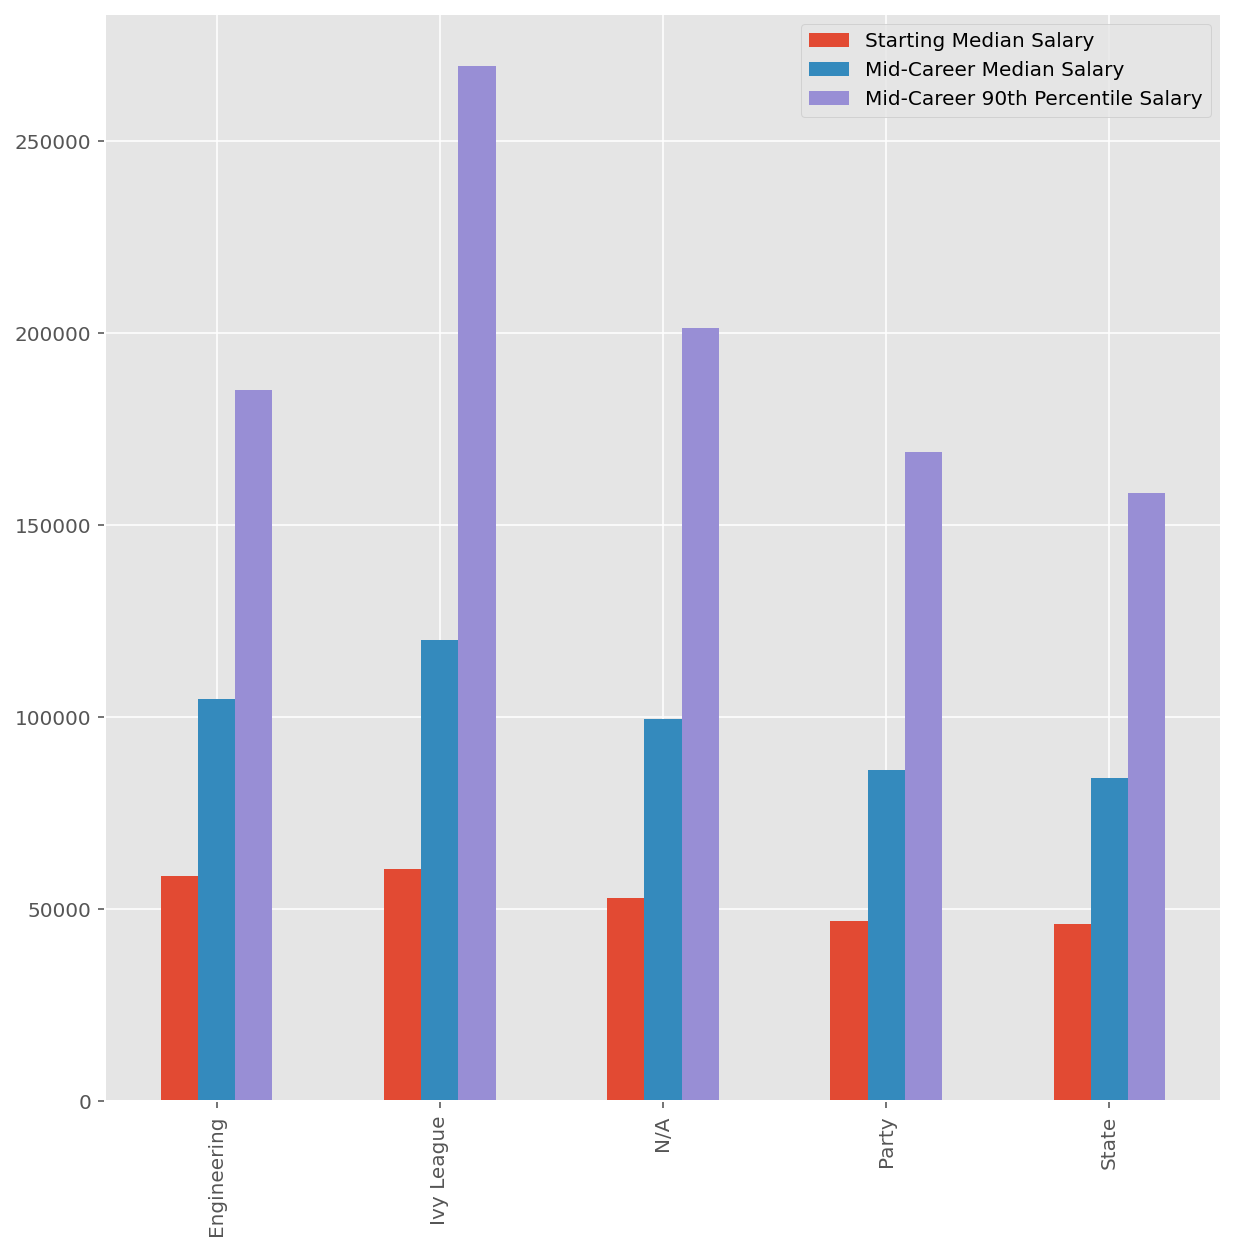

In [6]:
# Plotting median post-grad salaries by school type
univsal = univ[["School Type", "Starting Median Salary", "Mid-Career Median Salary", "Mid-Career 90th Percentile Salary"]].dropna(subset = "School Type").groupby("School Type").mean().reset_index()
plot = univsal.plot(kind='bar',figsize=(10,10)) # we are setting the type of plot to a bar graph
plot.set_xticklabels(univsal['School Type']);

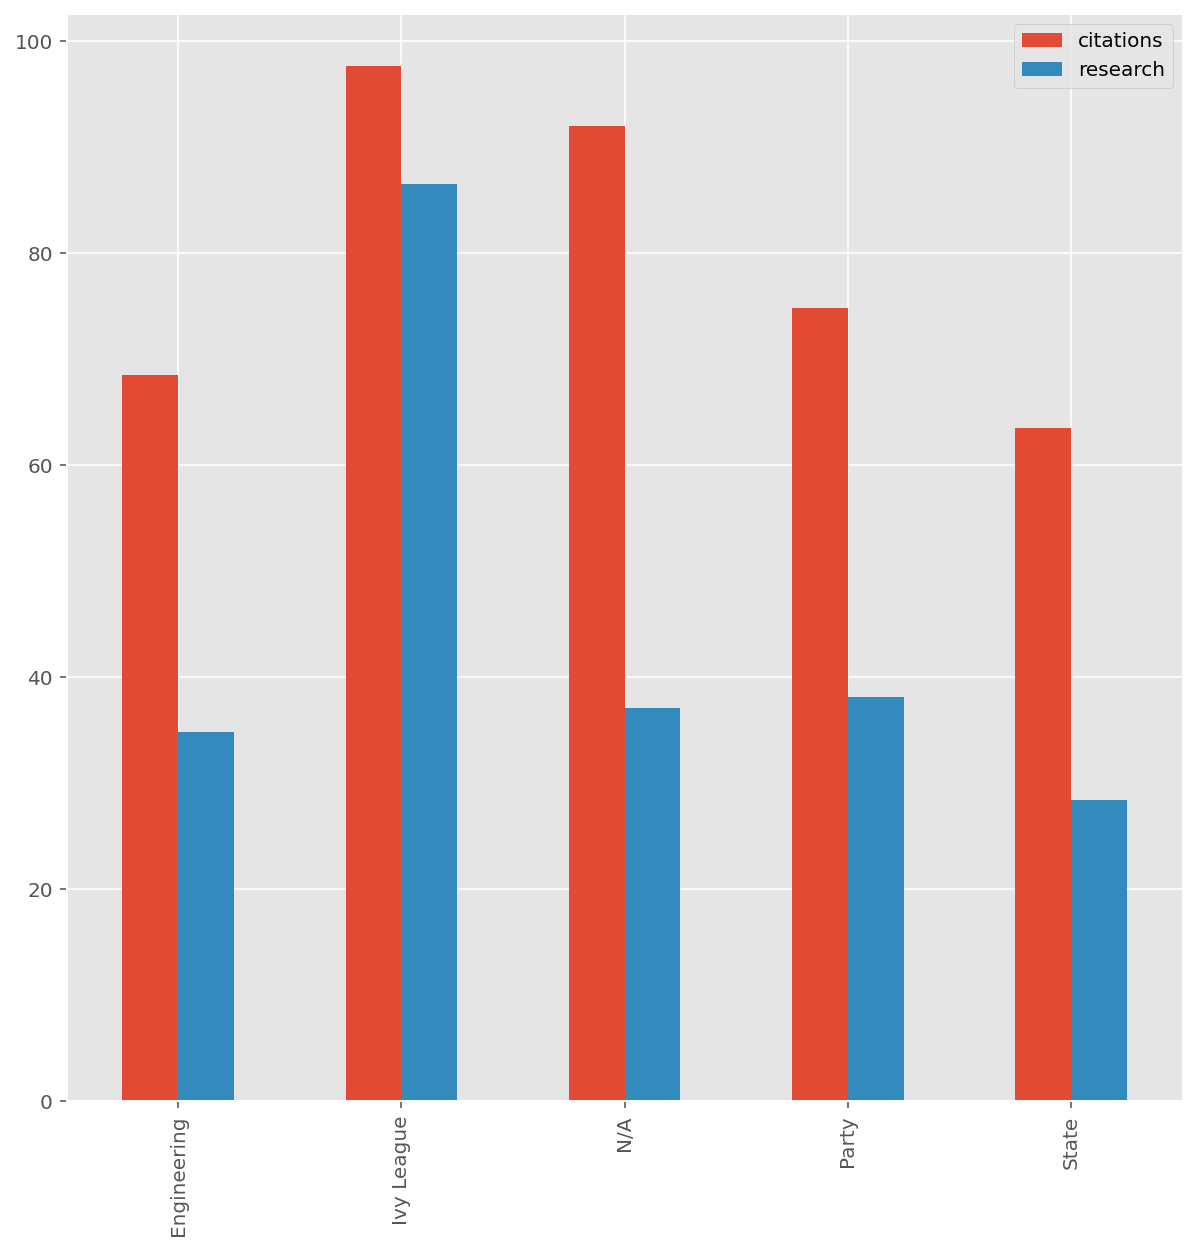

In [7]:
# Plotting median citation & research ratings by school type
univcitres = univ[["School Type", "citations", "research"]].groupby("School Type").median().reset_index()
plot = univcitres.plot(kind='bar',figsize=(10,10)) # we are setting the type of plot to a bar graph
plot.set_xticklabels(univsal['School Type']);

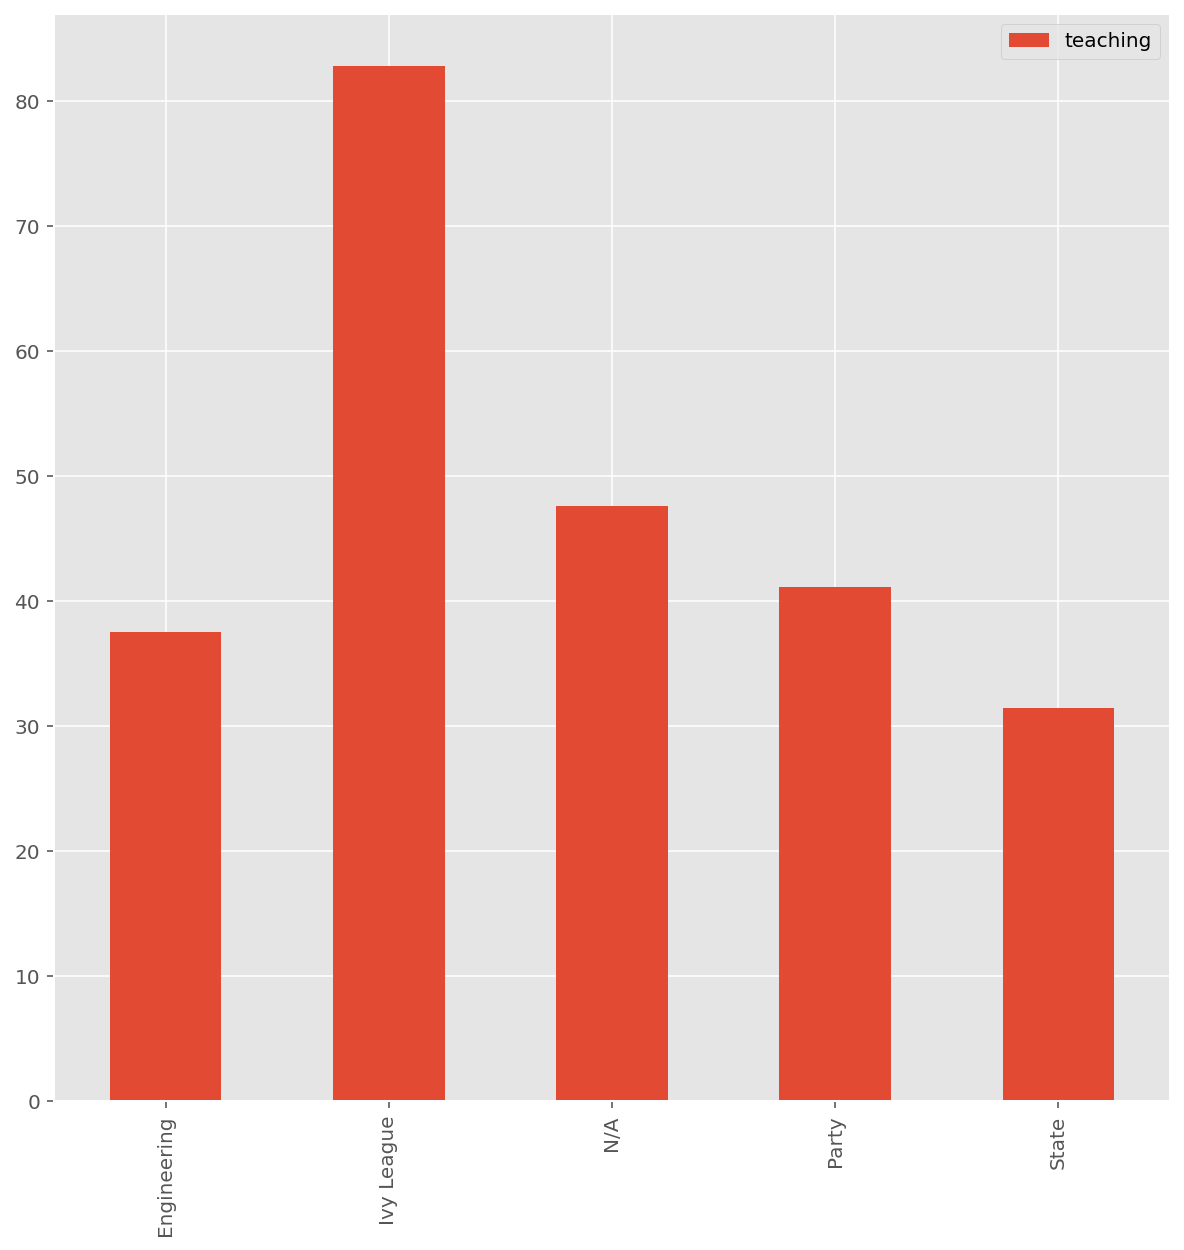

In [8]:
# Plotting teaching ratings by school type
univteach = univ[["School Type", "teaching"]].groupby("School Type").median().reset_index()
plot = univteach.plot(kind='bar',figsize=(10,10))
plot.set_xticklabels(univsal['School Type']);

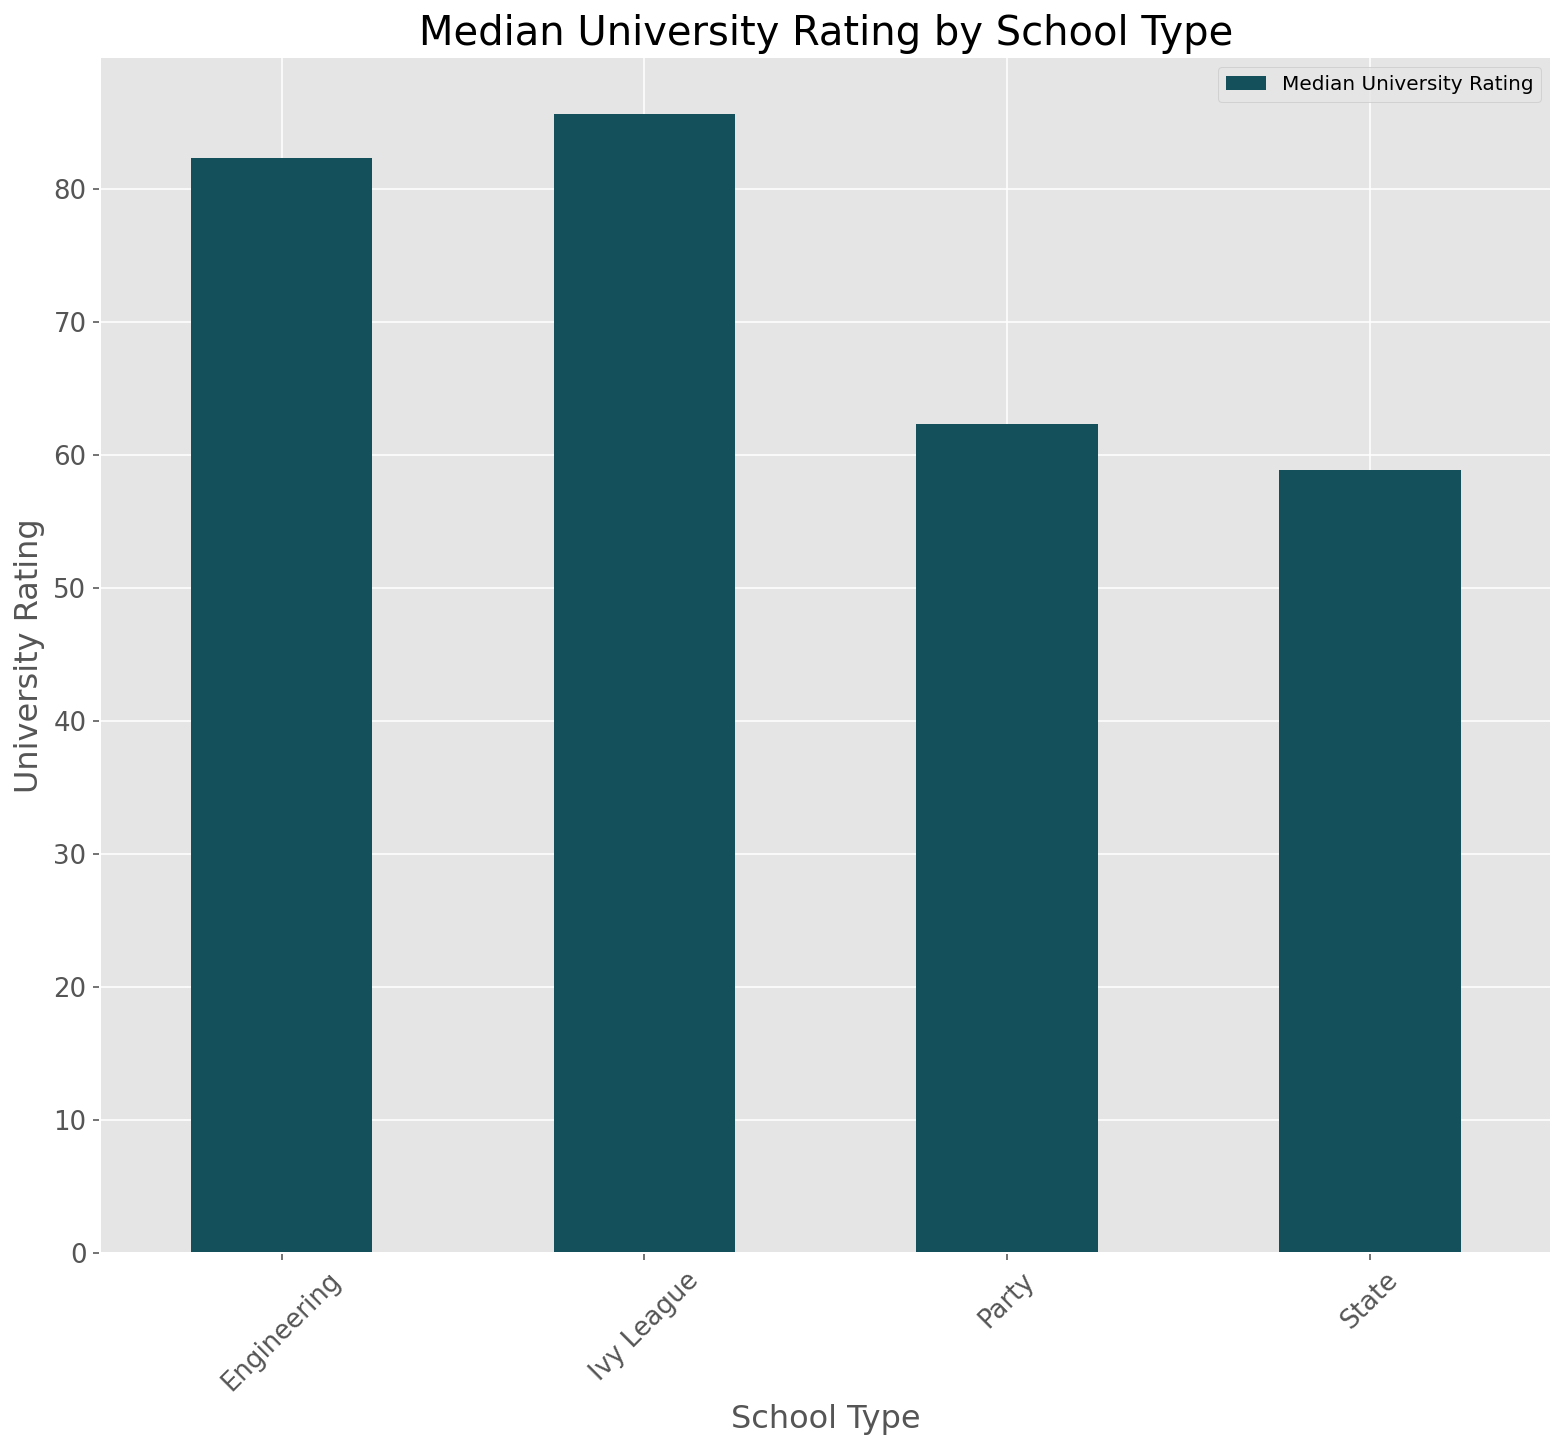

In [9]:
univtot = univ[["School Type", "total_score"]].groupby("School Type").median().reset_index()
univtot = univtot[univtot["School Type"] != "N/A"]
plot = univtot.plot(kind='bar',figsize=(13,11), color = '#144F5C')
plot.legend(labels = ["Median University Rating"])
plot.set_xticklabels(univtot['School Type'], rotation = 45)
plot.set_title("Median University Rating by School Type")
plot.title.set_size(20)
plot.set_xlabel("School Type")
plot.xaxis.label.set_size(16)
plot.set_ylabel("University Rating")
plot.yaxis.label.set_size(16)
plot.tick_params(axis='both', which='major', labelsize=13);
plot.get_figure().savefig("rating_by_school_type.jpg")

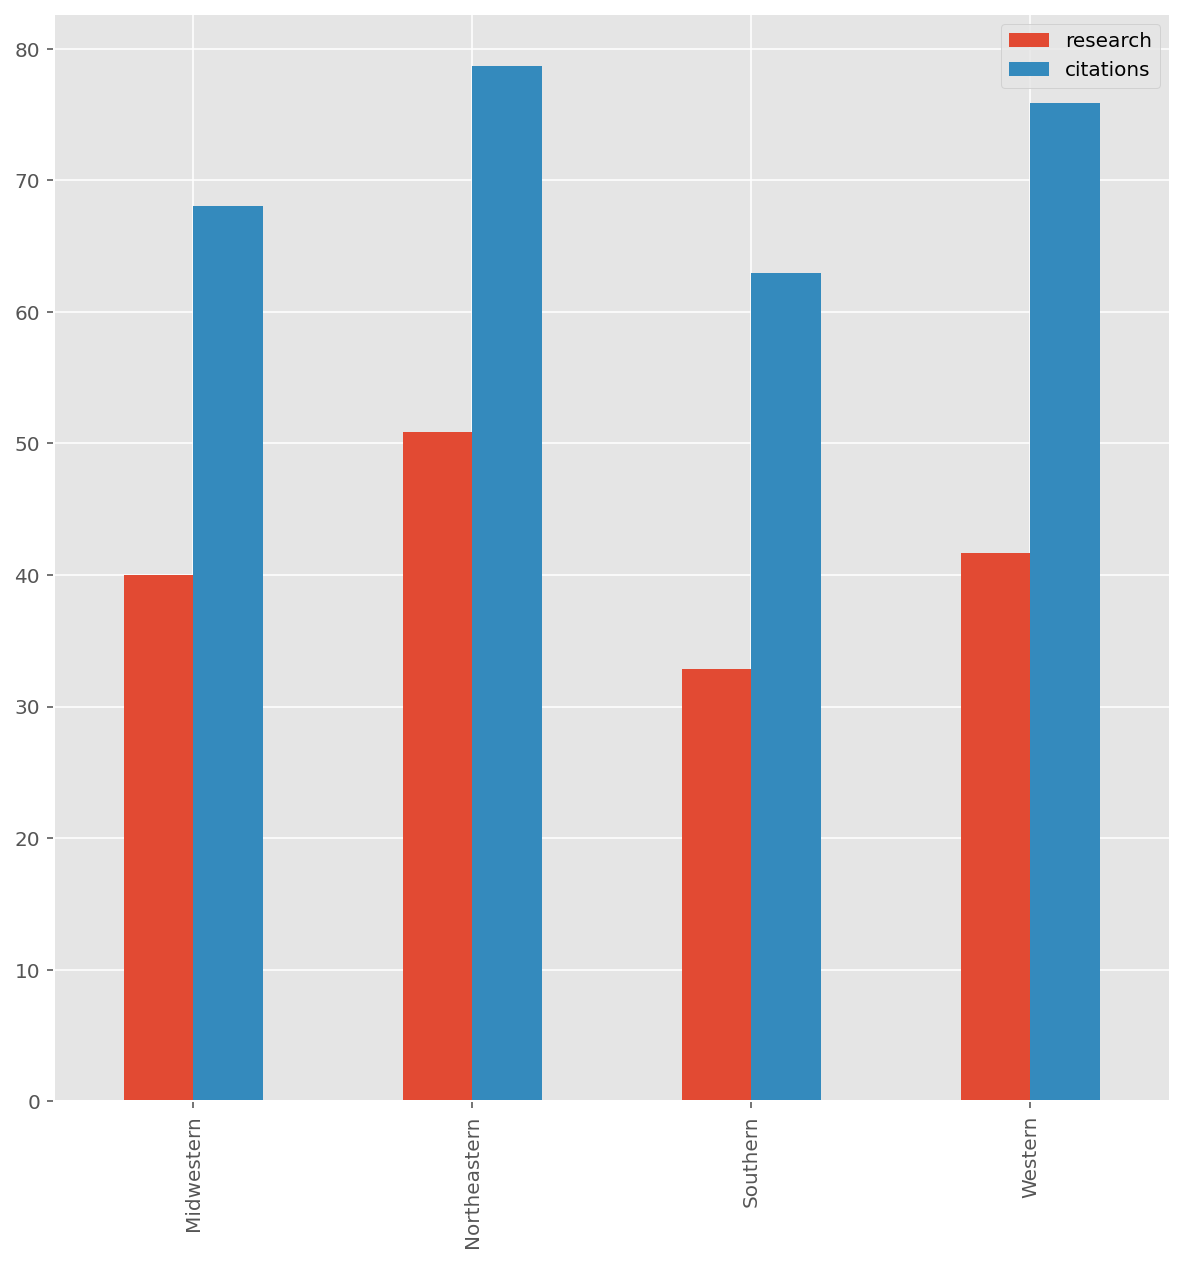

In [10]:
# Does the east really lean more towards academica?
univ2 = univ.copy()
univ2["Region"] = univ2["Region"].replace("California", "Western")
# Grouping California schools with Western schools
academia = univ2[["Region", "research", "citations"]].groupby("Region").mean().reset_index()
plot = academia.plot(kind='bar',figsize=(10,10))
plot.set_xticklabels(academia['Region']);

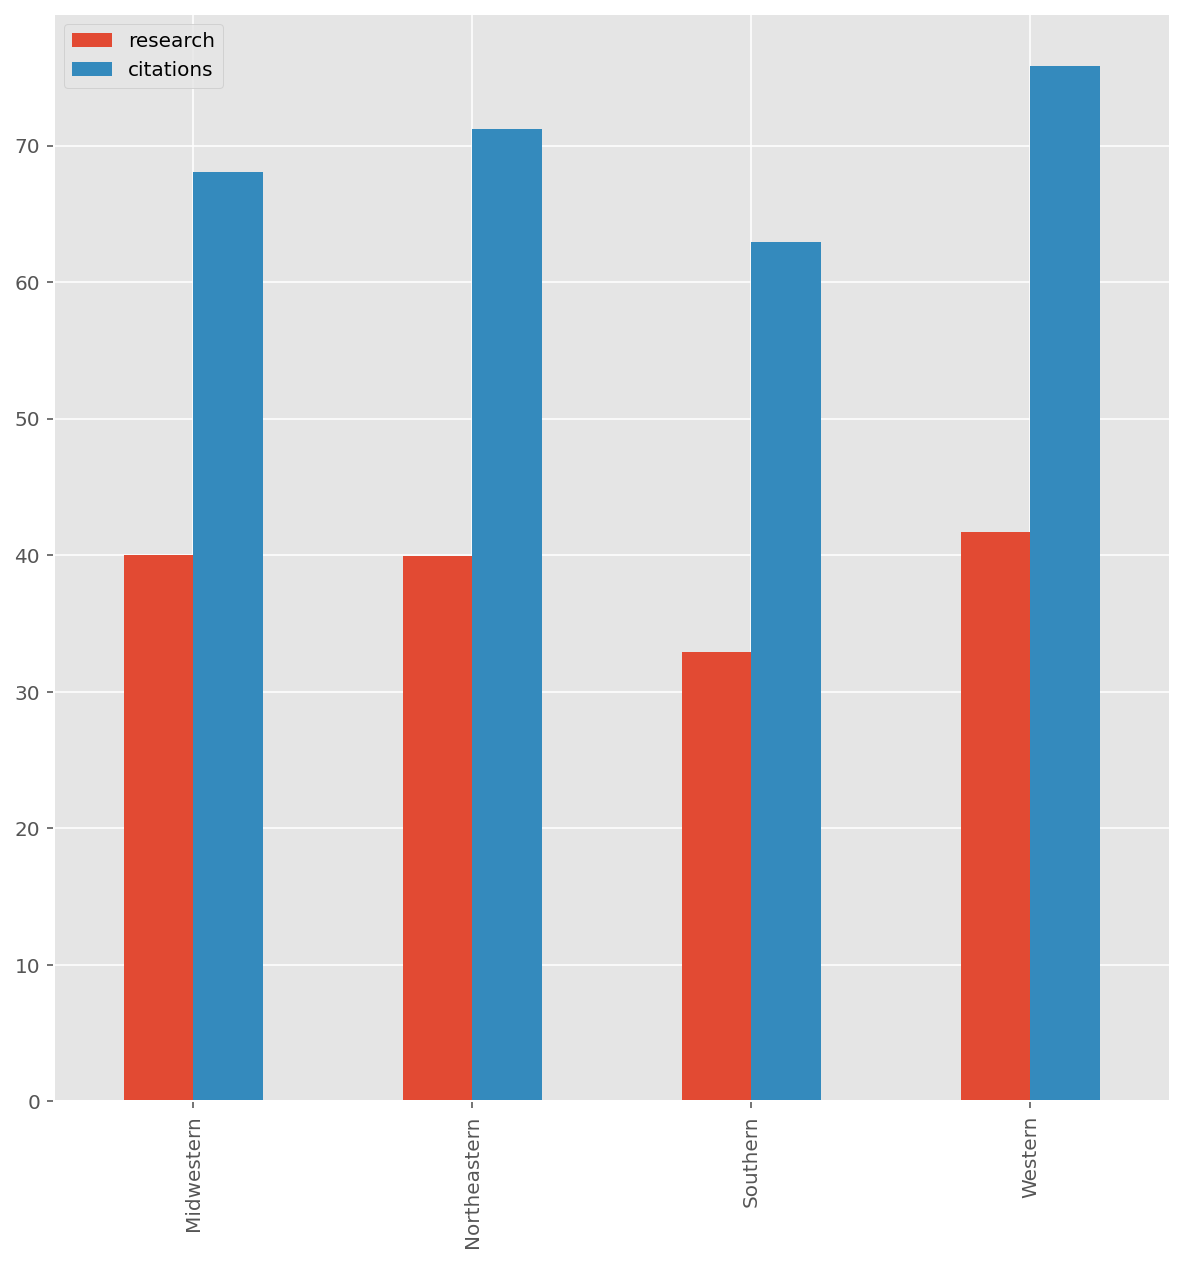

In [11]:
# Filtering out the ivies
univ_noivy = univ2[~univ2["School Type"].str.match("Ivy League", na = False)]
acad_noivy = univ_noivy[["Region", "research", "citations"]].groupby("Region").mean().reset_index()
plot = acad_noivy.plot(kind='bar',figsize=(10,10))
plot.set_xticklabels(acad_noivy['Region']);

In [12]:
# Create a score based on a few factors: Size (Small, Medium, Big), School Experience (Teaching, Ratio), Academia (Research, Citations), 
# Salary (Starting & Mid-Career Median Salary), Reputation (International Acclaim, Total Score), and Region (Southern, Northeastern, Western, California, or Midwestern
def generate_score(size=False, experience=False, academia=False, salary=False, reputation=False, region=False, ivies=True, df=univ):
    df["personal_score"] = 0.0
    metrics = [size, experience, academia, salary, reputation, region]
    multiplier = 1/sum([True for x in metrics if x != False])
    show = ["university_name"]
    
    if ivies == False:
        df = df[~df["School Type"].str.contains("Ivy League")]
    if size:
        show += ["num_students"]
        if size == "S":
            df.loc[df["School Size"].str.match("Small"), "personal_score"] += 100*multiplier
            df.loc[df["School Size"].str.match("Medium"), "personal_score"] += 75*multiplier
            df.loc[df["School Size"].str.match("Large"), "personal_score"] += 25*multiplier
        elif size == "M":
            df.loc[df["School Size"].str.match("Medium"), "personal_score"] += 100*multiplier
            df.loc[df["School Size"].str.match("Small"), "personal_score"] += 50*multiplier
            df.loc[df["School Size"].str.match("Large"), "personal_score"] += 50*multiplier
        elif size == "L":
            df.loc[df["School Size"].str.match("Large"), "personal_score"] += 100*multiplier
            df.loc[df["School Size"].str.match("Medium"), "personal_score"] += 75*multiplier
            df.loc[df["School Size"].str.match("Small"), "personal_score"] += 25*multiplier
            
    if experience:
        show += ["teaching"]
        show += ["student_staff_ratio"]
        df["personal_score"] += ((0.5)*(df["teaching"]) + (0.5)*(df["student_staff_ratio_index"]))*multiplier
        
    if academia:
        show += ["research"]
        show += ["citations"]
        df["personal_score"] += ((0.75)*(df["research"]) + (0.25)*(df["citations"]))*multiplier
    
    if salary:
        show += ["Salary Index"]
        show += ["Starting Median Salary"]
        df["personal_score"] += df["Salary Index"]*multiplier
        
    if reputation:
        show += ["international"]
        show += ["total_score"]
        df["personal_score"] += ((0.5)*(df["international"]) + (0.5)*(df["total_score"]))*multiplier
        
    if region:
        show += ["Region"]
        if region == "S":
            df.loc[df["Region"].str.match("Southern"), "personal_score"] += 100*multiplier
            df.loc[df["Region"].str.match("Western"), "personal_score"] += 60*multiplier
            df.loc[df["Region"].str.match("Northeastern"), "personal_score"] += 25*multiplier
            df.loc[df["Region"].str.match("California"), "personal_score"] += 50*multiplier
            df.loc[df["Region"].str.match("Midwestern"), "personal_score"] += 70*multiplier
        if region == "NE":
            df.loc[df["Region"].str.match("Northeastern"), "personal_score"] += 100*multiplier
            df.loc[df["Region"].str.match("Southern"), "personal_score"] += 25*multiplier
            df.loc[df["Region"].str.match("Western"), "personal_score"] += 40*multiplier
            df.loc[df["Region"].str.match("California"), "personal_score"] += 25*multiplier
            df.loc[df["Region"].str.match("Midwestern"), "personal_score"] += 70*multiplier
        if region == "W":
            df.loc[df["Region"].str.match("Western"), "personal_score"] += 100*multiplier
            df.loc[df["Region"].str.match("Southern"), "personal_score"] += 60*multiplier
            df.loc[df["Region"].str.match("Northeastern"), "personal_score"] += 40*multiplier
            df.loc[df["Region"].str.match("California"), "personal_score"] += 90*multiplier
            df.loc[df["Region"].str.match("Midwestern"), "personal_score"] += 70*multiplier
        if region == "C":
            df.loc[df["Region"].str.match("California"), "personal_score"] += 100*multiplier
            df.loc[df["Region"].str.match("Southern"), "personal_score"] += 50*multiplier
            df.loc[df["Region"].str.match("Northeastern"), "personal_score"] += 25*multiplier
            df.loc[df["Region"].str.match("Western"), "personal_score"] += 90*multiplier
            df.loc[df["Region"].str.match("Midwestern"), "personal_score"] += 60*multiplier
        if region == "MW":
            df.loc[df["Region"].str.match("Midwestern"), "personal_score"] += 100*multiplier
            df.loc[df["Region"].str.match("Southern"), "personal_score"] += 70*multiplier
            df.loc[df["Region"].str.match("Northeastern"), "personal_score"] += 70*multiplier
            df.loc[df["Region"].str.match("California"), "personal_score"] += 60*multiplier
            df.loc[df["Region"].str.match("Western"), "personal_score"] += 70*multiplier
        
    df["personal_score"] = df["personal_score"].apply(lambda x: round(x, 2))
        
    return df[["university_name", "personal_score"]].groupby("university_name").max().sort_values(by = "personal_score", 
                                                                                                  ascending = False).reset_index().merge(df[show], how = 'left', on = "university_name")[:5]

In [13]:
ex1 = generate_score(size = "M", region = "NE", reputation = True, academia = True, salary = True, ivies = False)
ex1["university_name"] = ["Massachusetts Institute of Technology", "Carnegie Mellon University", 
                          "University of Chicago", "University of Notre Dame", "New York University"]
ex1["num_students"] = ex1["num_students"].astype(int).apply(lambda x: str(x)[:2] + "," + str(x)[2:] if len(str(x)) == 5 else str(x)[:1] + "," + str(x)[1:])
ex1["Starting Median Salary"] = ex1["Starting Median Salary"].astype(int).apply(lambda x: "$" + str(x)[:2] + "," + str(x)[2:])
ex1.columns = ["Institution Name", "Personal Composite Score", "Student Population", "Research Score", "Citations Score",
               "Salary Index", "Starting Median Salary", "International Outlook Rating", "NY Times Score", "Region"]
ex1

/tmp/ipykernel_877320/2624490735.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["personal_score"] += ((0.75)*(df["research"]) + (0.25)*(df["citations"]))*multiplier
/tmp/ipykernel_877320/2624490735.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["personal_score"] += df["Salary Index"]*multiplier
/tmp/ipykernel_877320/2624490735.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,Institution Name,Personal Composite Score,Student Population,Research Score,Citations Score,Salary Index,Starting Median Salary,International Outlook Rating,NY Times Score,Region
0,Massachusetts Institute of Technology,95.88,"11,074",88.6,99.7,100.0,"$72,200",84.0,92.0,Northeastern
1,Carnegie Mellon University,91.02,"11,885",88.8,99.1,94.0,"$61,800",57.1,82.3,Northeastern
2,University of Chicago,84.61,"14,221",88.9,99.2,85.1,"$53,400",65.0,87.9,Midwestern
3,University of Notre Dame,74.02,"11,829",48.1,81.7,91.0,"$56,300",47.6,57.6,Midwestern
4,New York University,72.44,"42,056",72.3,95.3,70.9,"$50,300",49.3,77.2,Northeastern


In [14]:
ex2 = generate_score(size = "L", region = "W", reputation = True, experience = True)
ex2["university_name"] = ["Stanford University", "University of California, Los Angeles", "University of Washington", "University of California, Berkeley", "University of California, San Diego"]
ex2["num_students"] = ex2["num_students"].astype(int).apply(lambda x: str(x)[:2] + "," + str(x)[2:] if len(str(x)) == 5 else str(x)[:1] + "," + str(x)[1:])
ex2.columns = ["Institution Name", "Personal Composite Score", "Student Population", "Teaching Rating", "Student-to-Staff Ratio", "International Acclaim Rating", "NY Times Score", "Region"]
ex2

,Institution Name,Personal Composite Score,Student Population,Teaching Rating,Student-to-Staff Ratio,International Acclaim Rating,NY Times Score,Region
0,Stanford University,91.62,"15,596",92.5,7.8:1,76.3,93.9,California
1,"University of California, Los Angeles",85.17,"38,206",80.8,10.3:1,56.4,85.8,California
2,University of Washington,83.19,"44,020",67.1,11.8:1,51.2,75.6,Western
3,"University of California, Berkeley",82.49,"36,186",80.4,16.4:1,61.9,87.2,California
4,"University of California, San Diego",80.89,"27,233",56.9,6.5:1,42.9,72.2,California


/tmp/ipykernel_877320/1979568323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fulluniv["num_students"] = fulluniv["num_students"].astype(int)
/tmp/ipykernel_877320/1979568323.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fulluniv["total_score"] = fulluniv["total_score"].astype(float)


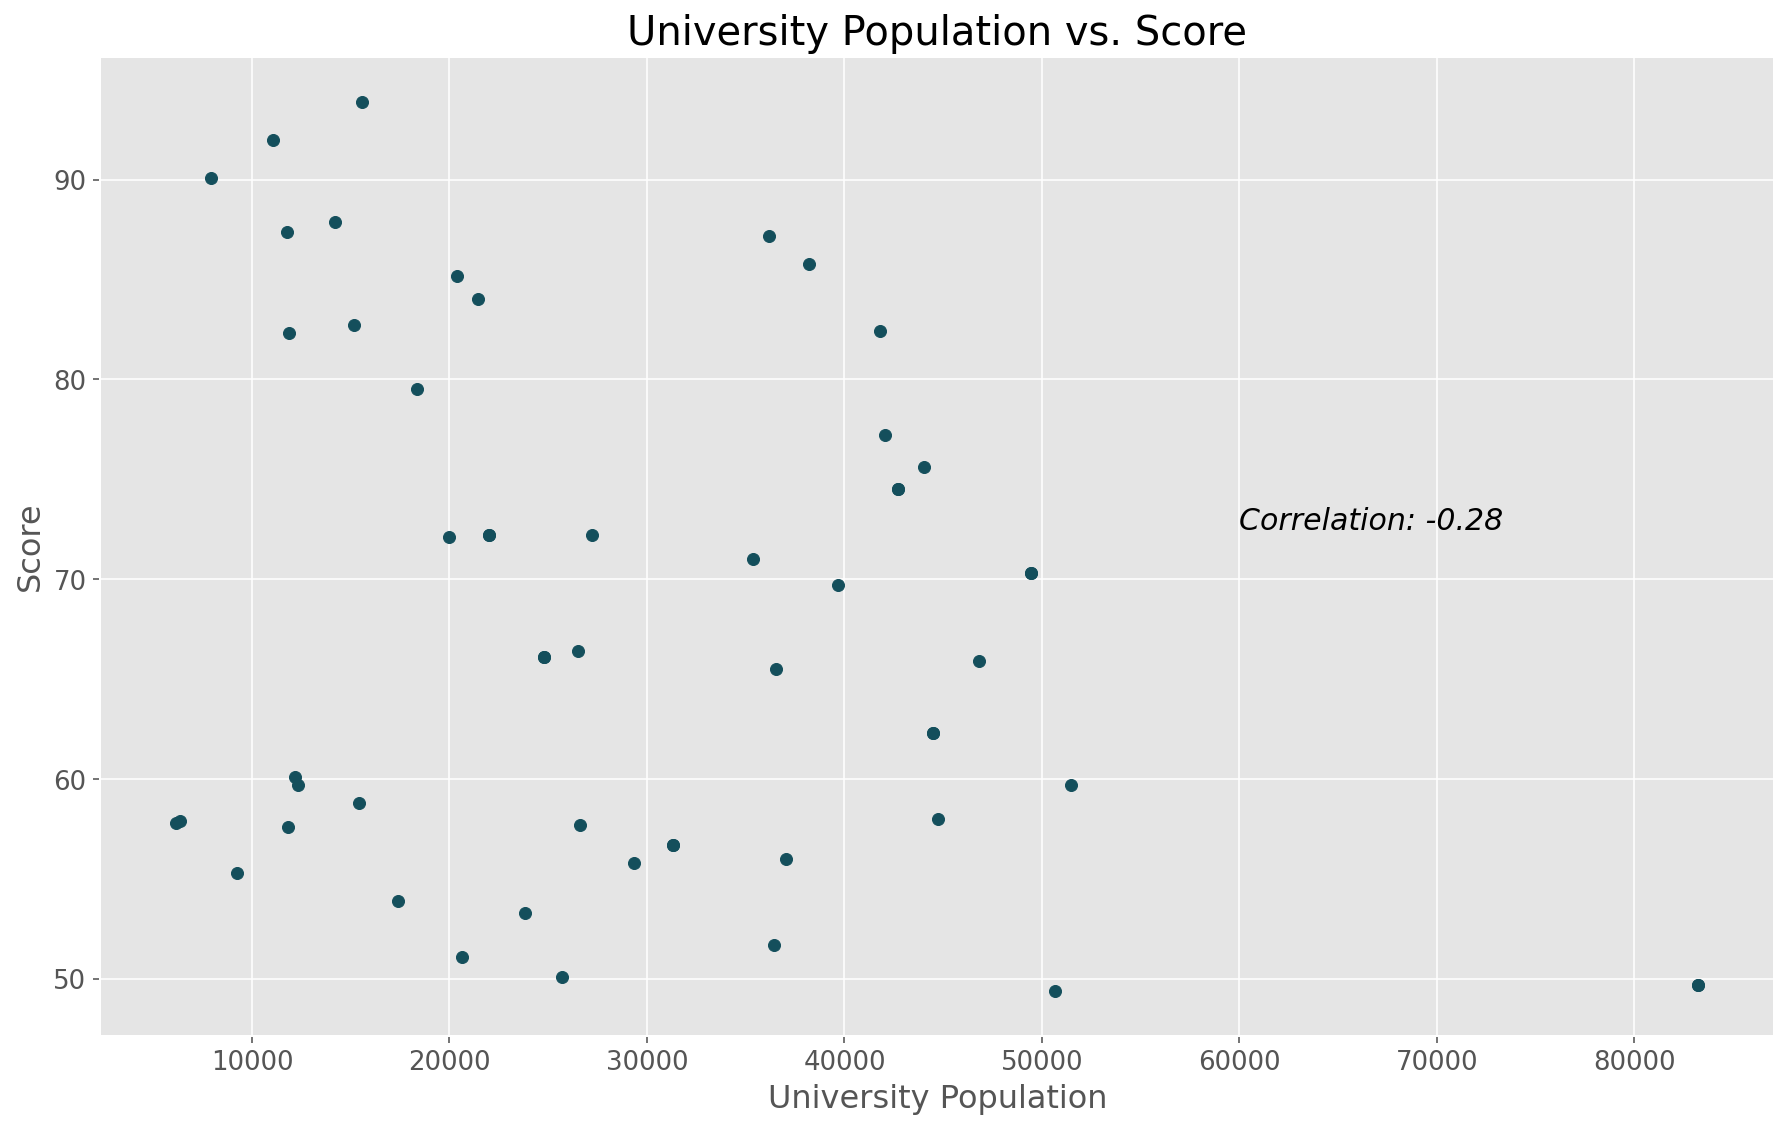

In [15]:
fulluniv = univ.dropna()
fulluniv["num_students"] = fulluniv["num_students"].astype(int)
fulluniv["total_score"] = fulluniv["total_score"].astype(float)
corr = np.corrcoef(fulluniv["num_students"], fulluniv["total_score"])[0, 1]
plt.figure(figsize=(15,9))
plt.scatter(fulluniv["num_students"], fulluniv["total_score"], marker = 'o', linestyle = '-', color = '#144F5C')
plt.xlabel('University Population', fontsize = 16)
plt.ylabel('Score', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('University Population vs. Score', fontsize = 20)
plt.text(60000, 72.5, f'Correlation: {corr:.2f}', fontsize=15, fontstyle = 'oblique');
plt.savefig("score_by_population.jpg")

In [16]:
whatevs = fulluniv[fulluniv["num_students"] < 60000]
np.corrcoef(whatevs["num_students"], whatevs["total_score"])[0, 1]

-0.14258174068482274

In [17]:
times

,index,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
1,2204,401-500,american washington dc,United States of America,42.2,28.9,16.5,41.1,35.9,-,"11,604",12.0,12%,60 : 40,2016
2,1965,163,arizona,United States of America,38.7,38.6,41.8,79.5,32.4,51.7,"36,429",12.7,8%,52 : 48,2016
3,1991,189,arizona state,United States of America,32.4,31.9,38.1,84.6,32.0,49.7,"83,236",29.9,9%,50 : 50,2016
4,2306,501-600,arkansas,United States of America,25.5,25.9,17.4,30.3,36.9,-,"22,819",21.2,5%,50 : 50,2016
6,2307,501-600,auburn,United States of America,30.2,27.9,19.4,21.0,37.2,-,"22,386",17.6,4%,51 : 49,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2203,351-400,wayne state,United States of America,31.9,29.6,14.2,65.3,41.7,-,"23,065",10.7,7%,57 : 43,2016
153,1852,50,wisconsin madison,United States of America,65.1,33.0,68.2,86.6,48.5,69.7,"39,655",10.8,11%,51 : 49,2016
154,2400,501-600,wisconsin milwaukee,United States of America,17.3,26.0,13.8,45.5,29.0,-,"22,542",18.4,5%,52 : 48,2016
155,1401,351-400,wyoming,United States of America,18.9,29.7,28.6,46.1,29.6,-,NaN,NaN,NaN,NaN,2014
